In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()


In [3]:
X = data.data
y = data.target

In [4]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)

y = pd.get_dummies(y1).values

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) 

# Building the network

In [6]:
import keras
from keras.optimizers import SGD
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint


def generate_model(input_nodes, hidden_nodes, output_nodes, learning_rate):
    model = Sequential()
    model.add(Dense(units=hidden_nodes,
                    kernel_initializer=keras.initializers.RandomUniform(-1, 1),
                    bias_initializer=keras.initializers.RandomUniform(-1, 1),
                    activation='sigmoid',
                    input_dim=input_nodes))
    model.add(Dense(units=output_nodes, 
                    kernel_initializer=keras.initializers.RandomUniform(-1, 1),
                    bias_initializer=keras.initializers.RandomUniform(-1, 1),
                    activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=learning_rate, momentum=0.0, nesterov=False, decay=0.0),
                  metrics=['accuracy']                  
                 )
    
    return model

Using TensorFlow backend.


In [7]:
import os
import shutil

dir = '/home/ricardo/mestrado/models/'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.mkdir(dir)

epochs = 1000
learning_rate = 0.0001
hidden_nodes = 10000
input_nodes = X_train.shape[1]
output_nodes = y_train.shape[1]

model = generate_model(input_nodes, hidden_nodes, output_nodes, learning_rate)

save_model_checkpoint = ModelCheckpoint(dir + 'weights.{epoch:04d}-{val_loss:.5f}-{val_acc:.5f}.hdf5',
                                            verbose=0, 
                                            save_best_only=False,                                           
                                            save_weights_only=False,
                                            mode='auto',                                           
                                            period=1)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    callbacks=[save_model_checkpoint],
                    verbose=0
                   )

In [8]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [9]:
print('best accuracy: %.3f' % max(history.history['acc']))
print('best validation accuracy: %.3f' % max(history.history['val_acc']))

best accuracy: 0.996
best validation accuracy: 0.886


# Weight analysis

In [10]:
def output_data(layer):
    print('min :', np.min(layer))
    print('std-:', np.average(layer)-np.std(layer))
    print('avg :', np.average(layer))
    print('std+:', np.average(layer)+np.std(layer))
    print('max :', np.max(layer))
    print()
    
def bias_not_zeros(l):
    return l.shape[0] - np.sum(abs(l) < 1e-10)

def weight_input_not_zeros(l):
    return bias_not_zeros(np.abs(l).sum(axis=1))

def weight_output_not_zeros(l):
    return bias_not_zeros(np.abs(l).sum(axis=0))

m = generate_model(input_nodes, hidden_nodes, output_nodes, learning_rate)
def process_epoch(n):
    files = sorted(os.listdir(dir))    
    filename = dir+files[n]
    m.load_weights(filename)

    first_layer_weights = m.layers[0].get_weights()[0]
    first_layer_biases = m.layers[0].get_weights()[1]
    second_layer_weights = m.layers[1].get_weights()[0]
    second_layer_biases = m.layers[1].get_weights()[1]
    
    return {
        'w1': first_layer_weights,
        'w1nzi': weight_input_not_zeros(first_layer_weights),
        'w1nzo': weight_output_not_zeros(first_layer_weights),
        'b1': first_layer_biases,
        'b1nz': bias_not_zeros(first_layer_biases),
        'w2': second_layer_weights,
        'w2nzi': weight_input_not_zeros(second_layer_weights),
        'w2nzo': weight_output_not_zeros(second_layer_weights),
        'b2': second_layer_biases,
        'b2nz': bias_not_zeros(second_layer_biases)
    }

a = process_epoch(0)

# Graphics

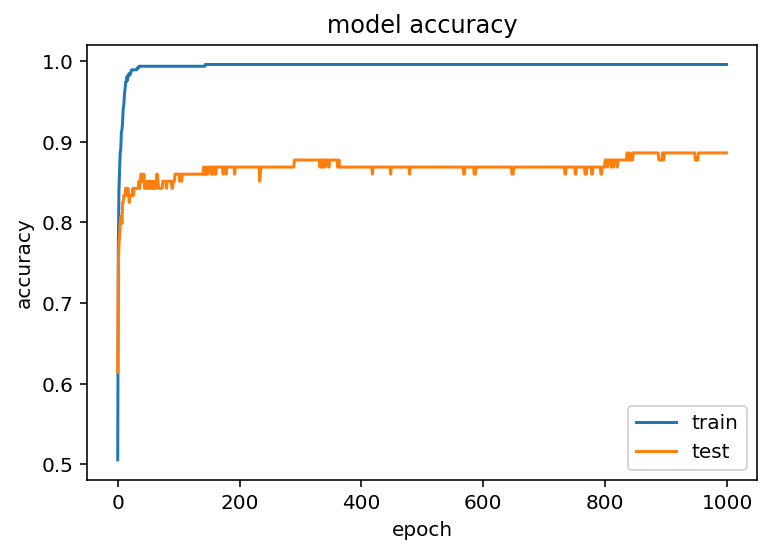

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
# plt.ylim([0.8, 1.0])
plt.show()

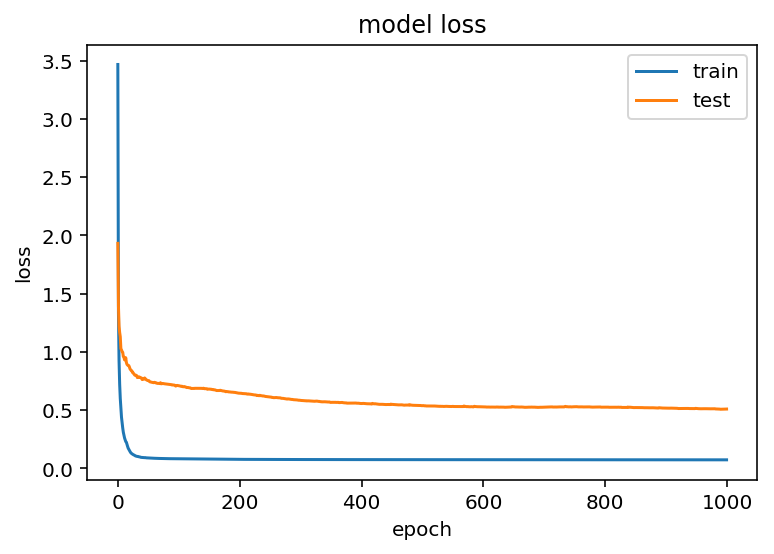

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
# plt.ylim([.1, .3])
plt.show()

In [13]:
first_layer_weight_avg = []
first_layer_bias_avg = []
first_layer_bias_not_zero = []
w1nzi = []
w1nzo = []

second_layer_weight_avg = []
second_layer_bias_avg = []
second_layer_bias_not_zero = []
w2nzi = []
w2nzo = []

for i in range(epochs):
    r = process_epoch(i)
    first_layer_weight_avg.append(np.average(np.abs(r['w1'])))
    first_layer_bias_avg.append(np.average(np.abs(r['b1'])))
    first_layer_bias_not_zero.append(r['b1nz'])
    w1nzi.append(r['w1nzi'])
    w1nzo.append(r['w1nzo'])
    
    second_layer_weight_avg.append(np.average(np.abs(r['w2'])))
    second_layer_bias_avg.append(np.average(np.abs(r['b2'])))
    second_layer_bias_not_zero.append(r['b2nz'])
    w2nzi.append(r['w2nzi'])
    w2nzo.append(r['w2nzo'])

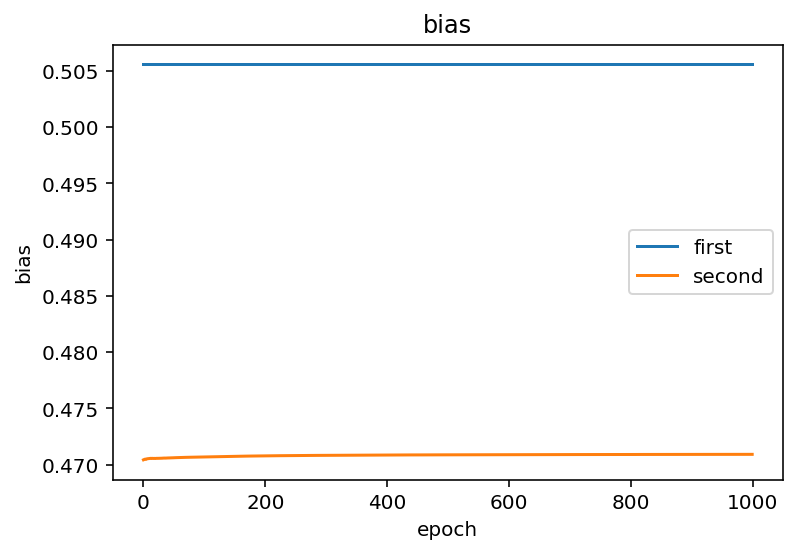

In [14]:
plt.plot(first_layer_bias_avg)
plt.plot(second_layer_bias_avg)
plt.title('bias')
plt.ylabel('bias')
plt.xlabel('epoch')
plt.legend(['first', 'second'], loc='best')
# plt.ylim([-3e-9, 6e-9])
# plt.ylim([, 6e-9])
plt.show()

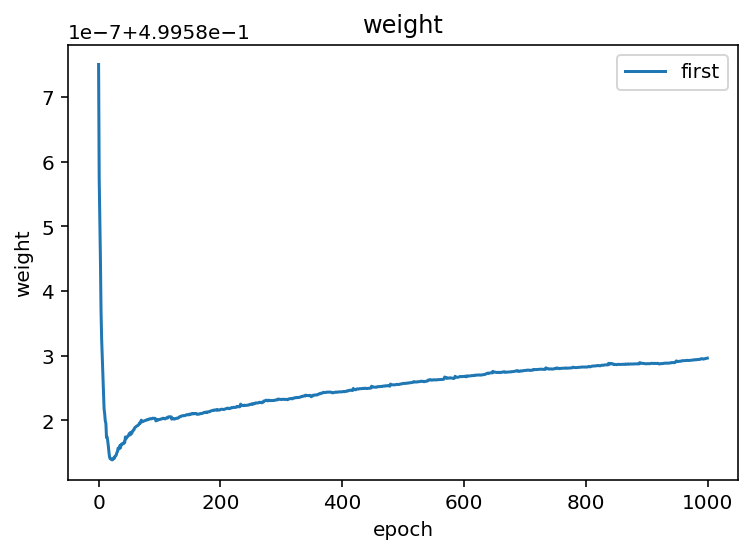

In [15]:
plt.plot(first_layer_weight_avg)
plt.title('weight')
plt.ylabel('weight')
plt.xlabel('epoch')
plt.legend(['first'], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()

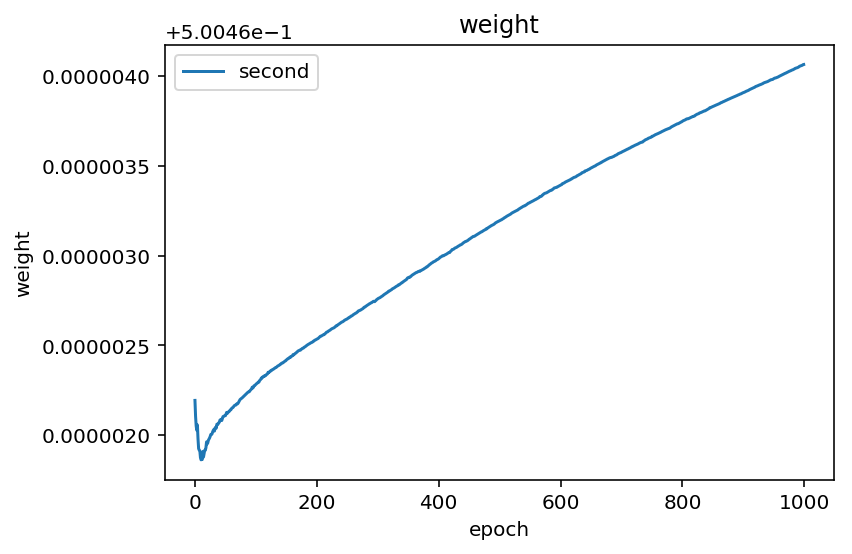

In [16]:
plt.plot(second_layer_weight_avg)
plt.title('weight')
plt.ylabel('weight')
plt.xlabel('epoch')
plt.legend(['second'], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()

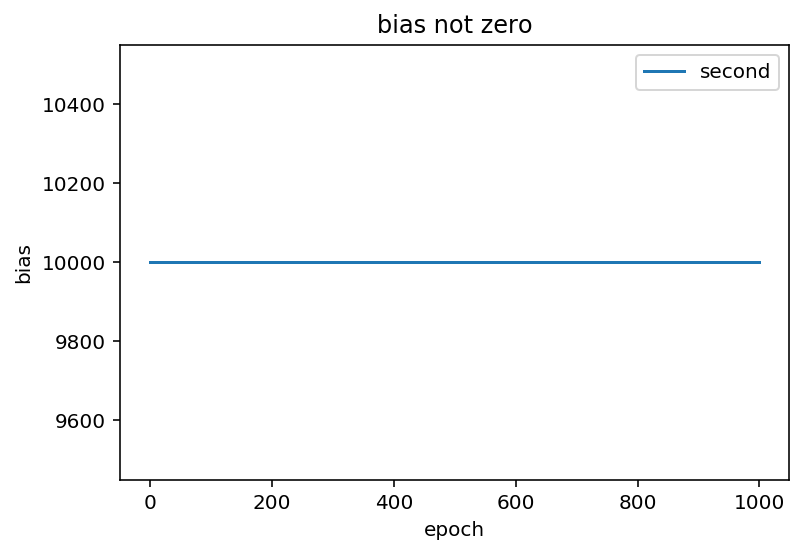

In [17]:
plt.plot(first_layer_bias_not_zero)
plt.title('bias not zero')
plt.ylabel('bias')
plt.xlabel('epoch')
plt.legend(['second'], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()

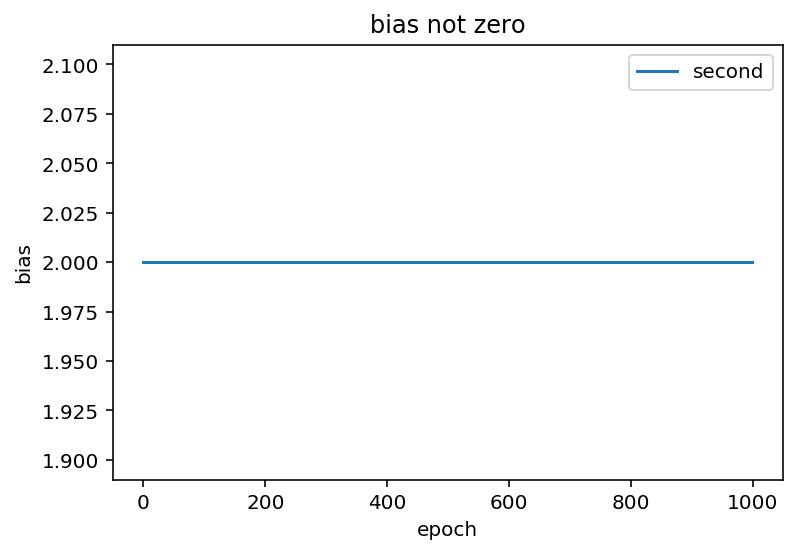

In [18]:
plt.plot(second_layer_bias_not_zero)
plt.title('bias not zero')
plt.ylabel('bias')
plt.xlabel('epoch')
plt.legend(['second'], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()

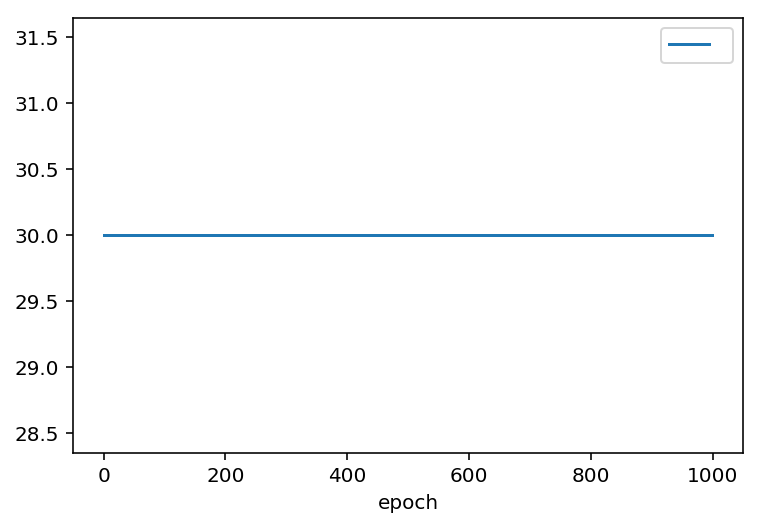

In [19]:
plt.plot(w1nzi)
plt.title('')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend([''], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()

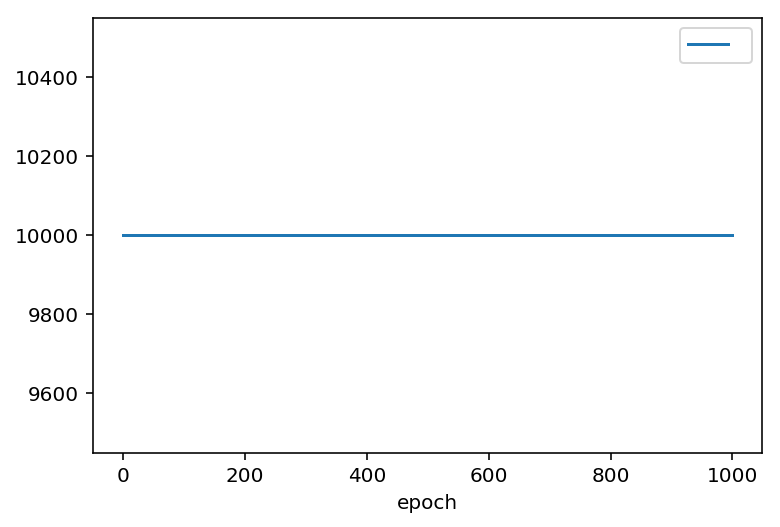

In [20]:
plt.plot(w1nzo)
plt.title('')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend([''], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()

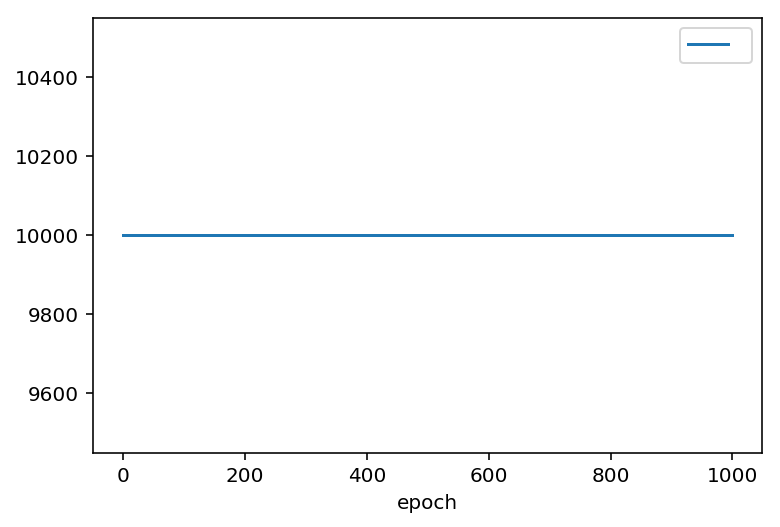

In [21]:
plt.plot(w2nzi)
plt.title('')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend([''], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()

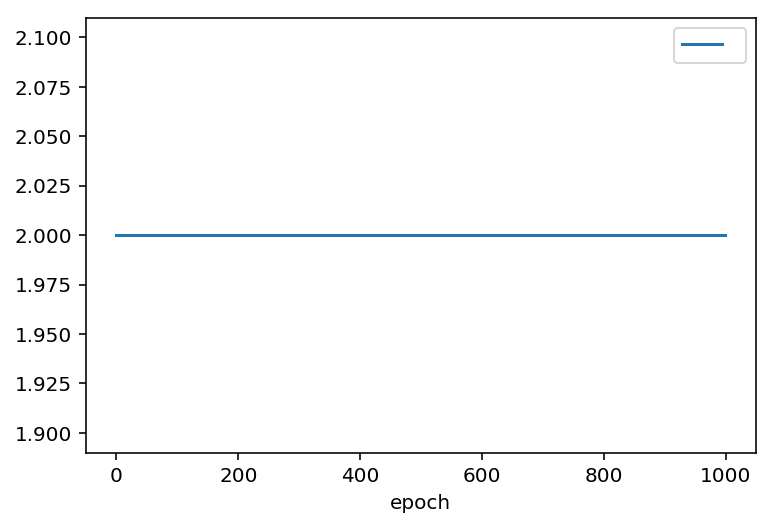

In [22]:
plt.plot(w2nzo)
plt.title('')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend([''], loc='best')
# plt.ylim([-1e-7, 3e-7])
plt.show()